In [1]:
from train_mlp import muMLPTab9, SP_MLP, NTK_MLP, train, preload_subset

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import copy
import os
import pandas as pd
import math

device = "cuda"

# export visible cuda to only use GPU 7
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

dl = preload_subset(128, 0.2)
test_batch = next(iter(dl))

In [2]:
def coord_check(model, batch, optimizer, loss_fn):
    model_copy = copy.deepcopy(model)
    model_copy.zero_grad()
    optimizer = optimizer(model_copy.parameters())
    x, y = batch[0], batch[1]
    x = x.to(device)
    y = y.to(device)
    
    pred, pre_update = model_copy(x, record_activations=True)
    
    loss = loss_fn(pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    with torch.no_grad():
        _, activations = model_copy(x, record_activations=True)

    pi = {}
    eps = {}

    for k in range(len(pre_update)):
        a0 = torch.Tensor(pre_update[k]).view(x.size(0), -1)     # (B, dim)
        a1 = torch.Tensor(activations[k]).view(x.size(0), -1)    # post-update

        pi[k]  = a1.abs().mean().item()
        eps[k] = (a1 - a0).abs().mean().item()

    return pi, eps

In [3]:
results = {}
widths = [128, 512, 1024, 2048, 4096, 8192, 16384]

for width in widths:
    print(f"Width: {width}")
    model = muMLPTab9(width).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(10):
        for batch in dl:
            x, y = batch[0], batch[1]
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        results[(width, epoch)] = coord_check(model, test_batch, torch.optim.SGD, loss_fn)

Width: 128
Width: 512
Width: 1024
Width: 2048
Width: 4096
Width: 8192
Width: 16384


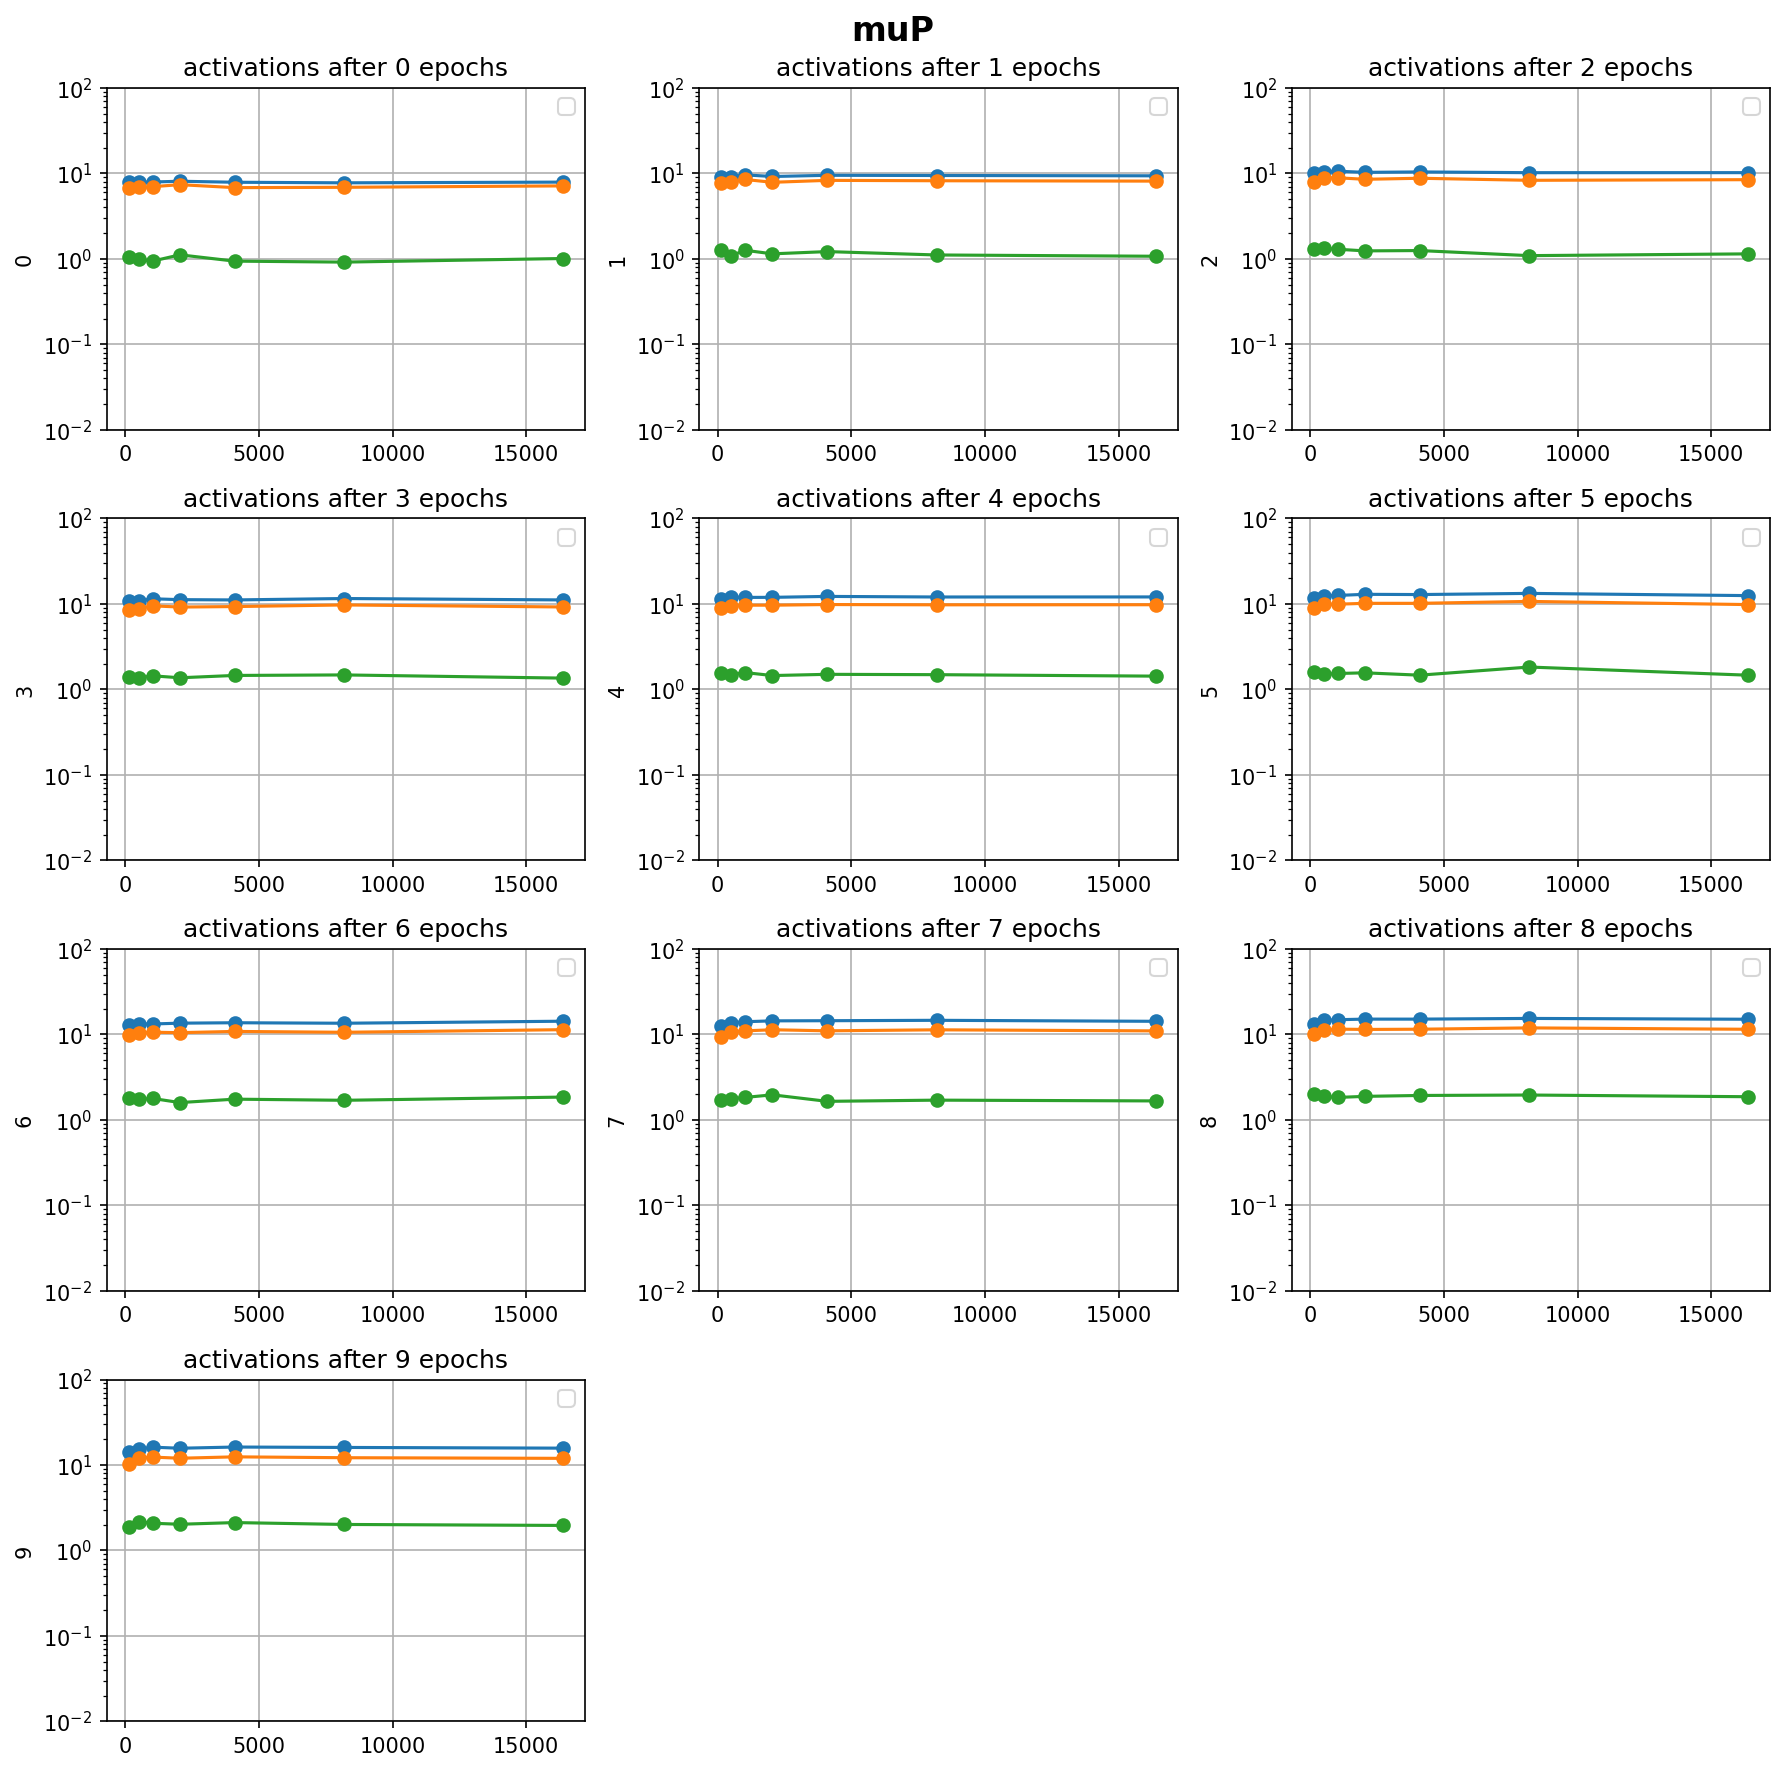

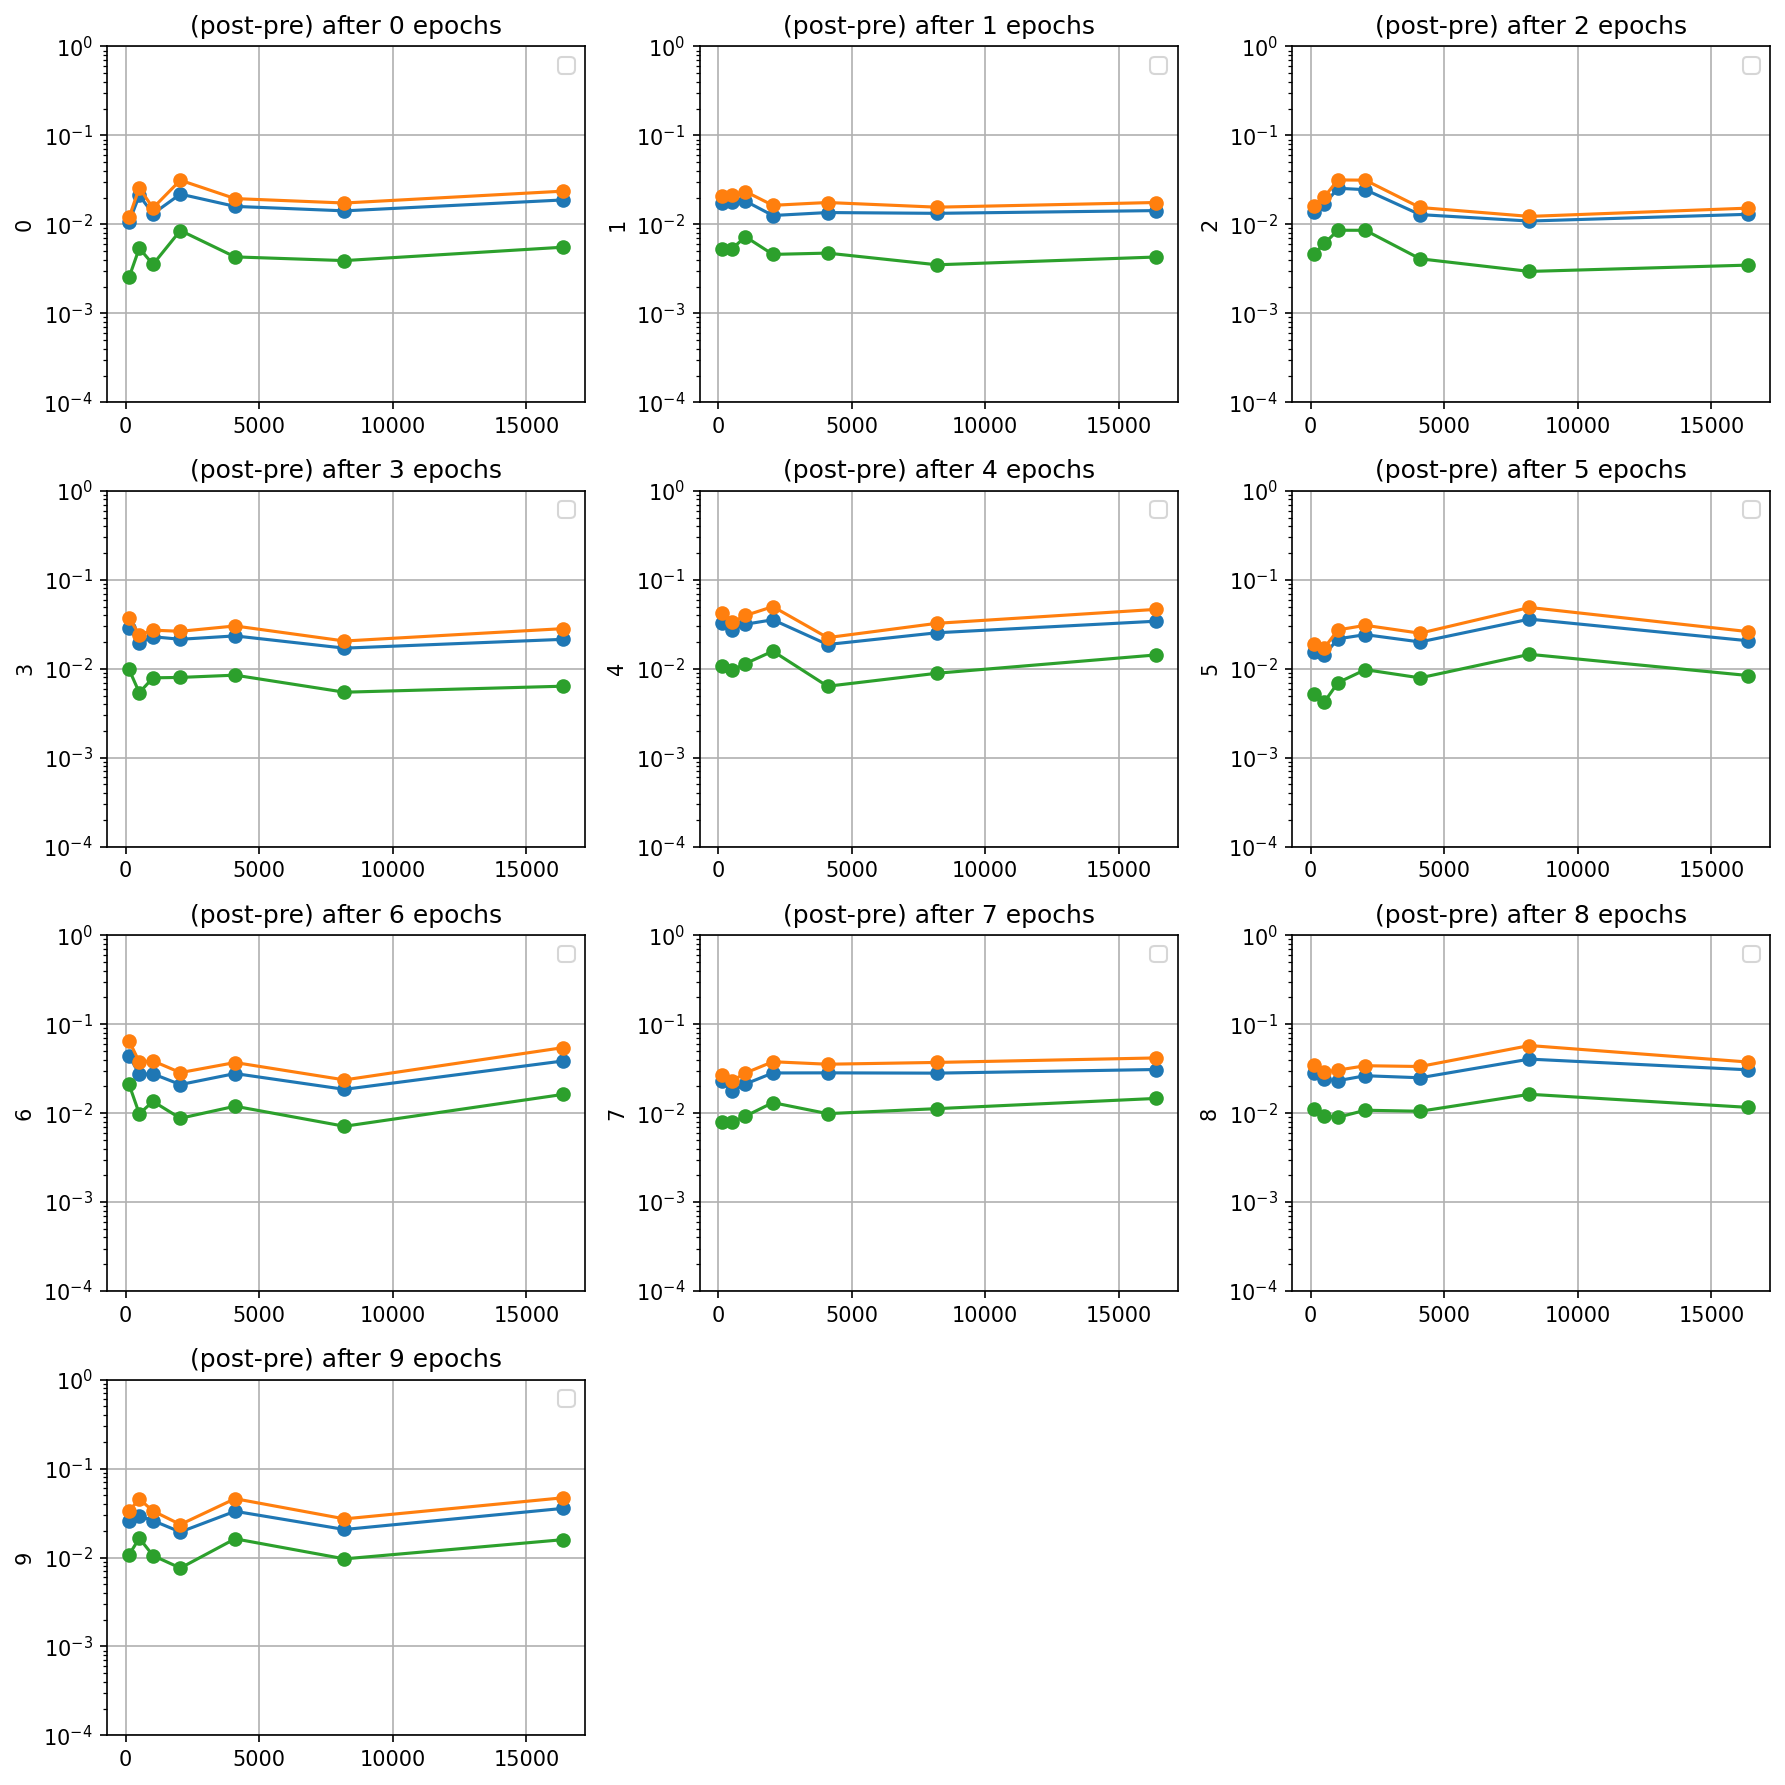

In [26]:
df = pd.DataFrame(results).apply(lambda x: pd.Series(x[0]).apply(pd.Series).stack()).droplevel(1, axis=0)

# Number of unique second-level metrics (e.g., 'loss', 'acc', etc.)
second_levels = df.columns.levels[1]
n_metrics = len(second_levels)
n_cols = 3
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), dpi=150)
axes = axes.flatten()

for i, second_level in enumerate(second_levels):
    ax = axes[i]
    df_slice = df.xs(second_level, axis=1, level=1).T
    df_slice.plot(ax=ax, marker="o")
    ax.set_title(f'activations after {second_level} epochs')
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_ylabel(second_level)
    ax.set_ylim(1e-2, 1e2)
    ax.grid(True)
    ax.legend([])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('muP', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

df = pd.DataFrame(results).apply(lambda x: pd.Series(x[1]).apply(pd.Series).stack()).droplevel(1, axis=0)

second_levels = df.columns.levels[1]
n_metrics = len(second_levels)
n_cols = 3
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), dpi=150)
axes = axes.flatten()

for i, second_level in enumerate(second_levels):
    ax = axes[i]
    df_slice = df.xs(second_level, axis=1, level=1).T
    df_slice.plot(ax=ax, marker="o")
    ax.set_title(f'(post-pre) after {second_level} epochs')
    ax.set_xlabel('')
    ax.set_yscale('log')
    ax.set_ylim(1e-4, 1e0)
    ax.set_ylabel(second_level)
    ax.grid(True)
    ax.legend([])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [5]:
resultsSP = {}
widths = [128, 512, 1024, 2048, 4096, 8192, 16384]

for width in widths:
    print(f"Width: {width}")
    model = SP_MLP(width).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=.1)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(10):
        for batch in dl:
            x, y = batch[0], batch[1]
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        resultsSP[(width, epoch)] = coord_check(model, test_batch, torch.optim.SGD, loss_fn)

Width: 128
Width: 512
Width: 1024
Width: 2048
Width: 4096
Width: 8192
Width: 16384


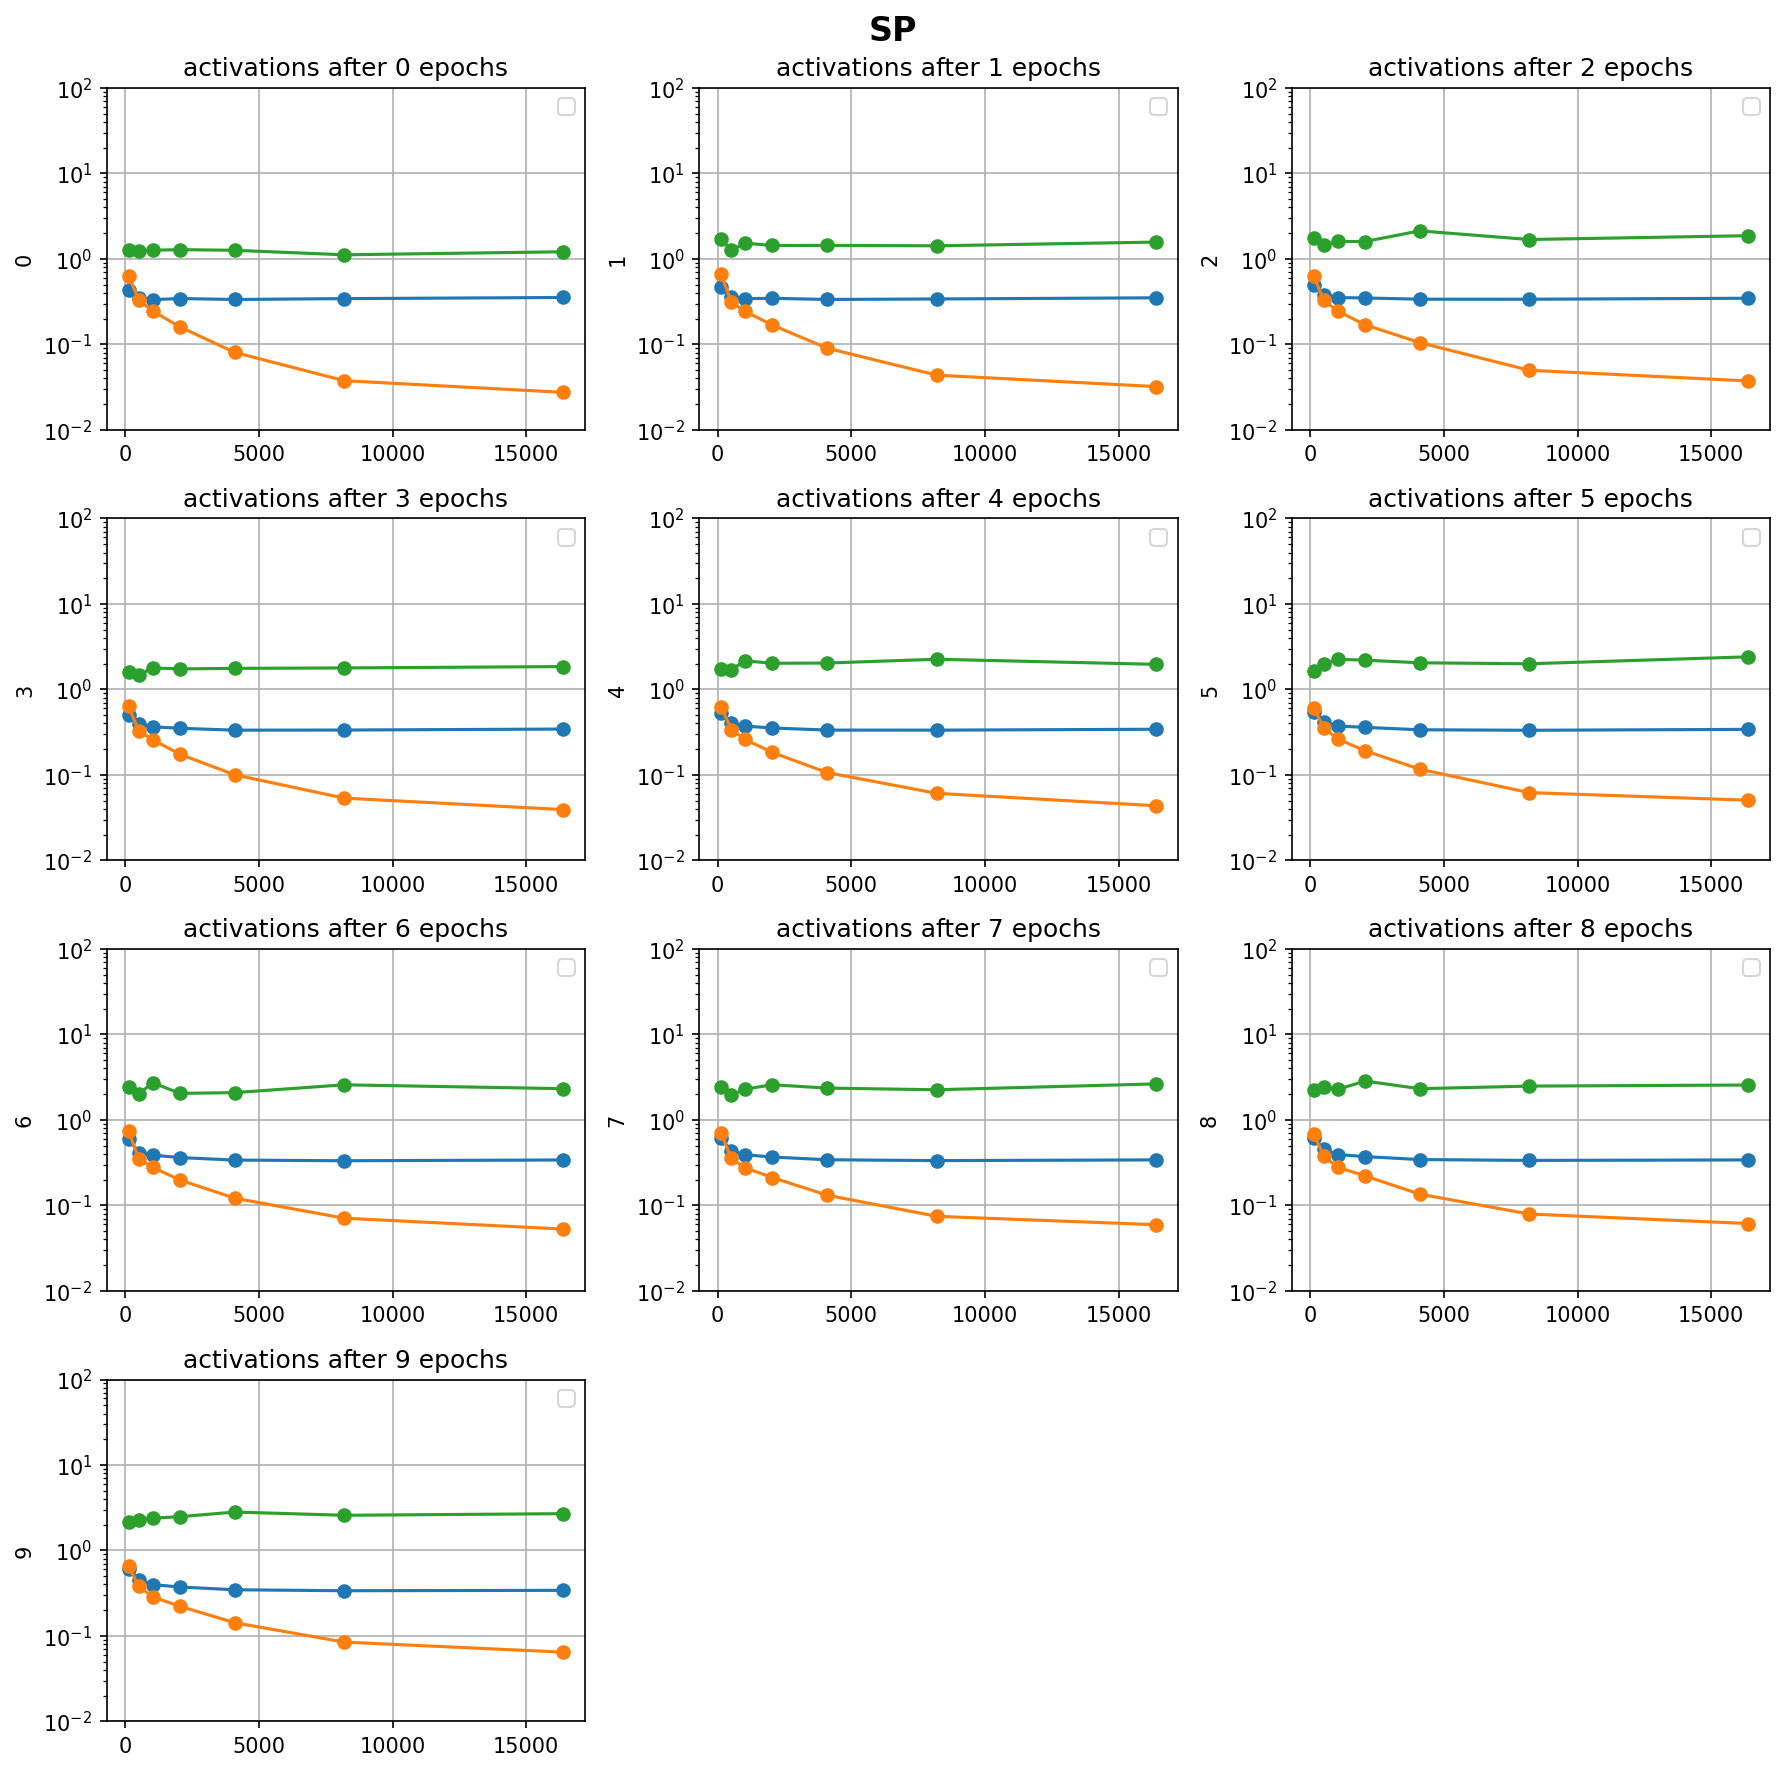

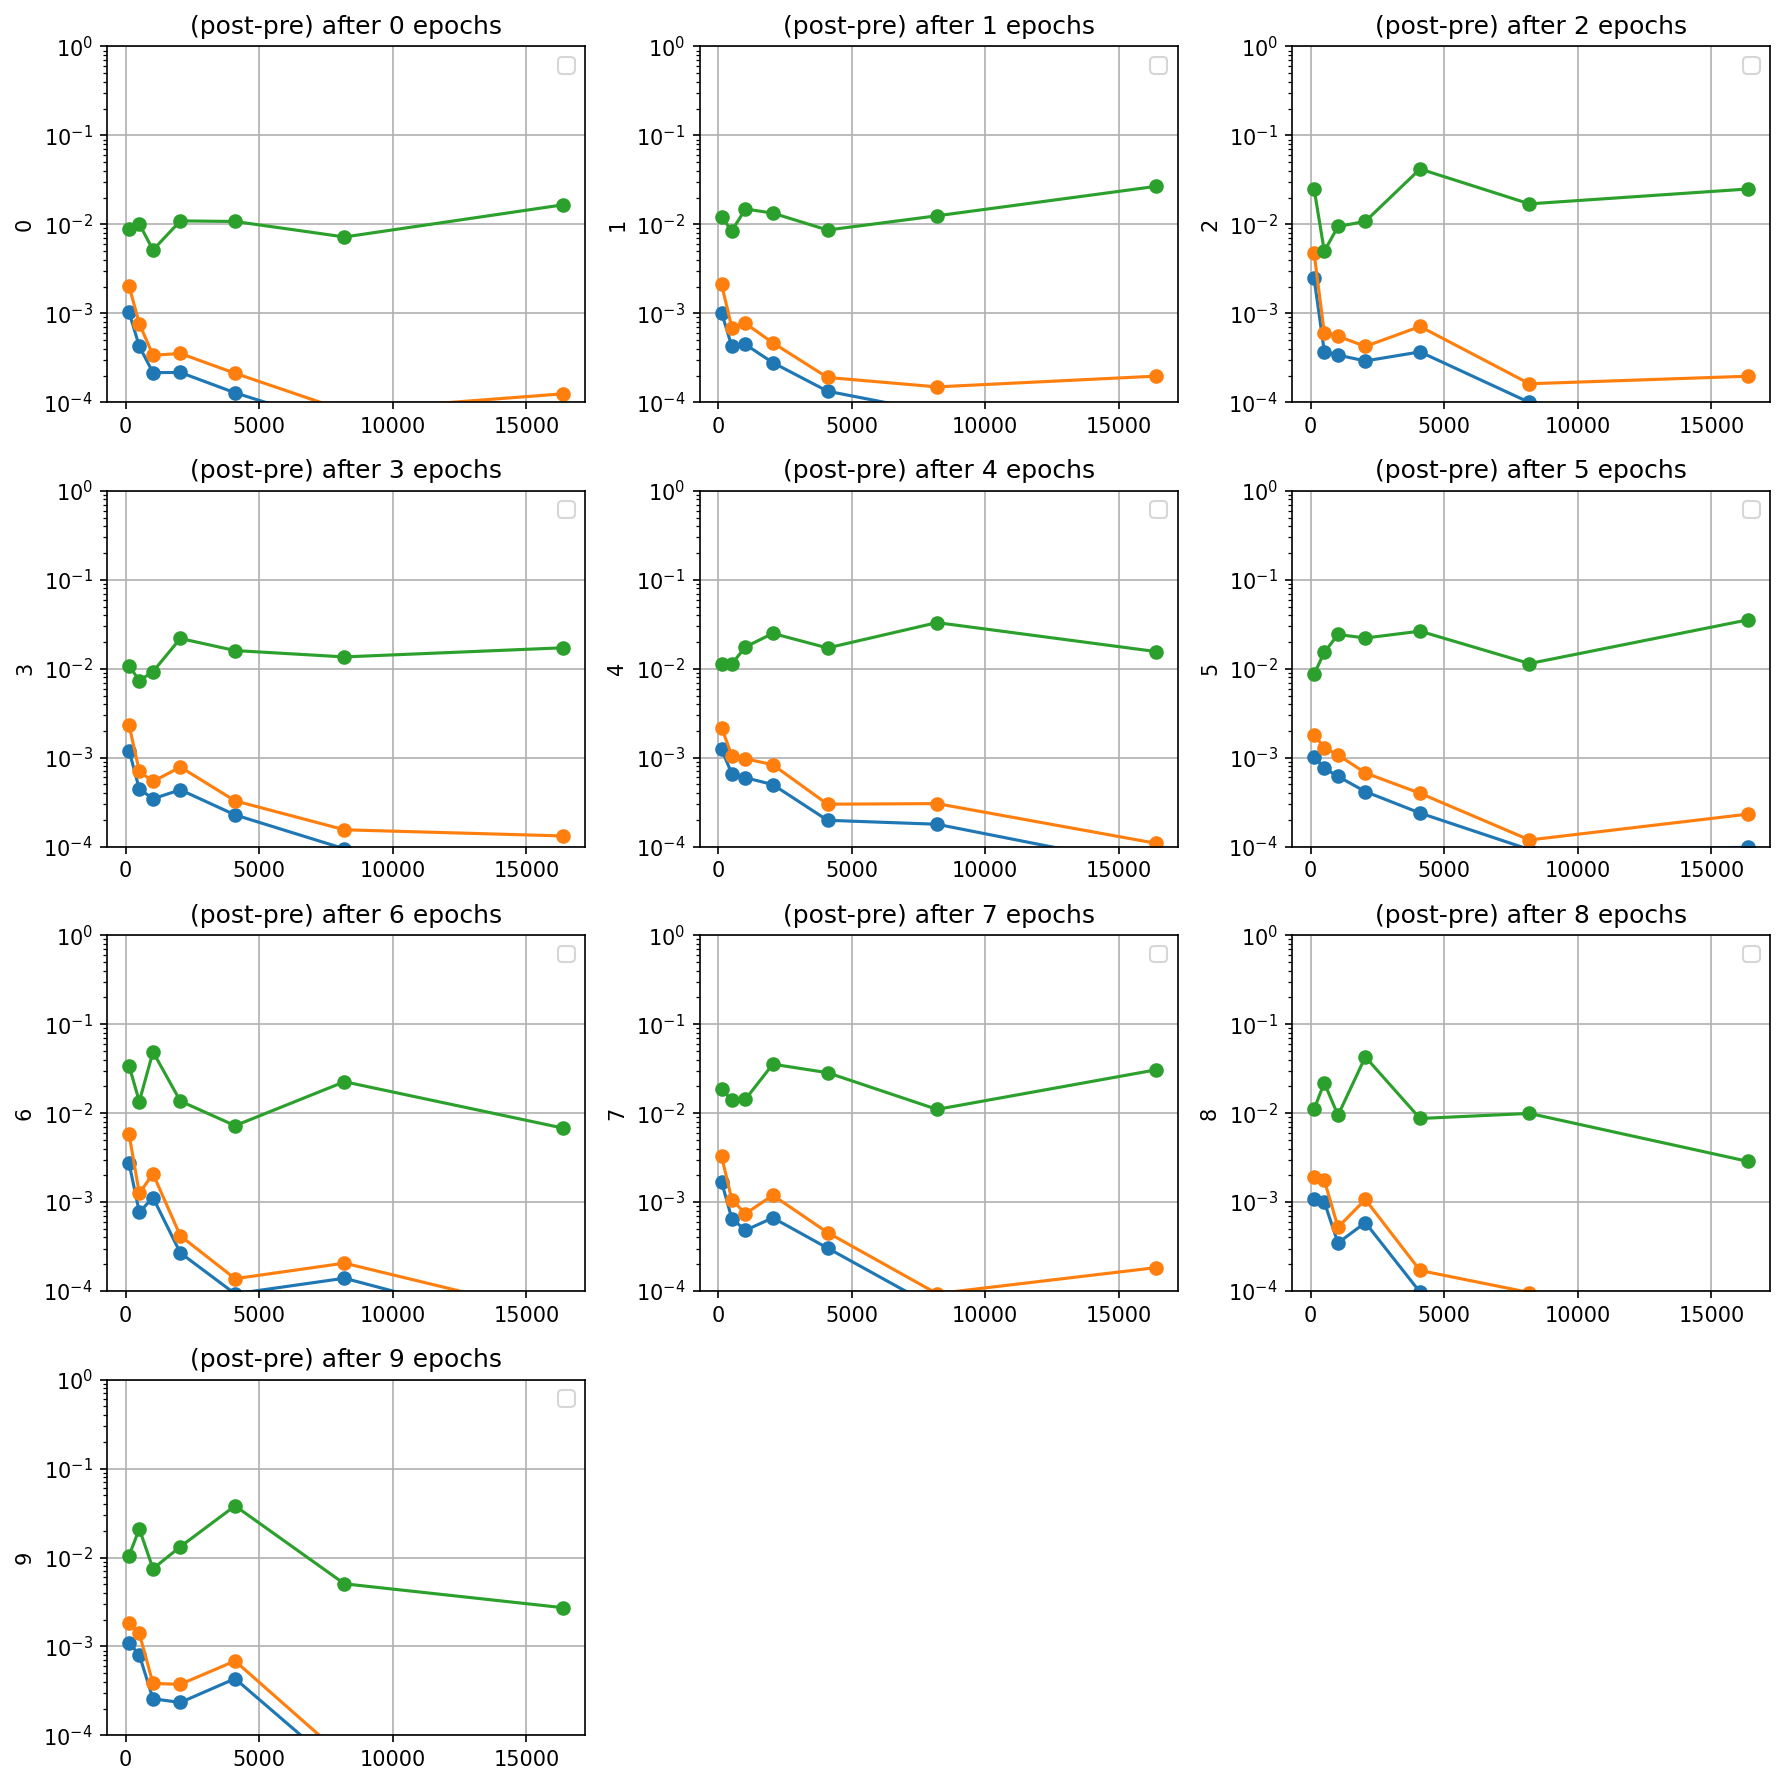

In [28]:
dfSP = pd.DataFrame(resultsSP).apply(lambda x: pd.Series(x[0]).apply(pd.Series).stack()).droplevel(1, axis=0)

# Number of unique second-level metrics (e.g., 'loss', 'acc', etc.)
second_levels = dfSP.columns.levels[1]
n_metrics = len(second_levels)
n_cols = 3
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), dpi=150)
axes = axes.flatten()

for i, second_level in enumerate(second_levels):
    ax = axes[i]
    df_slice = dfSP.xs(second_level, axis=1, level=1).T
    df_slice.plot(ax=ax, marker="o")
    ax.set_title(f'activations after {second_level} epochs')
    ax.set_xlabel('')
    ax.set_ylim(1e-2, 1e2)
    ax.set_yscale('log')
    ax.set_ylabel(second_level)
    ax.grid(True)
    ax.legend([])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('SP', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

dfSP = pd.DataFrame(resultsSP).apply(lambda x: pd.Series(x[1]).apply(pd.Series).stack()).droplevel(1, axis=0)

# Number of unique second-level metrics (e.g., 'loss', 'acc', etc.)
second_levels = dfSP.columns.levels[1]
n_metrics = len(second_levels)
n_cols = 3
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), dpi=150)
axes = axes.flatten()

for i, second_level in enumerate(second_levels):
    ax = axes[i]
    df_slice = dfSP.xs(second_level, axis=1, level=1).T
    df_slice.plot(ax=ax, marker="o")
    ax.set_title(f'(post-pre) after {second_level} epochs')
    ax.set_xlabel('')
    ax.set_ylim(1e-4, 1e0)
    ax.set_yscale('log')
    ax.set_ylabel(second_level)
    ax.grid(True)
    ax.legend([])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [11]:
resultsNTK = {}
widths = [128, 512, 1024, 2048, 4096, 8192, 16384]

for width in widths:
    print(f"Width: {width}")
    model = NTK_MLP(width).to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=.1)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(10):
        for batch in dl:
            x, y = batch[0], batch[1]
            x, y = x.to(device), y.to(device)
            pred = model(x)
            
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        resultsNTK[(width, epoch)] = coord_check(model, test_batch, torch.optim.SGD, loss_fn)

Width: 128
Width: 512
Width: 1024
Width: 2048
Width: 4096
Width: 8192
Width: 16384


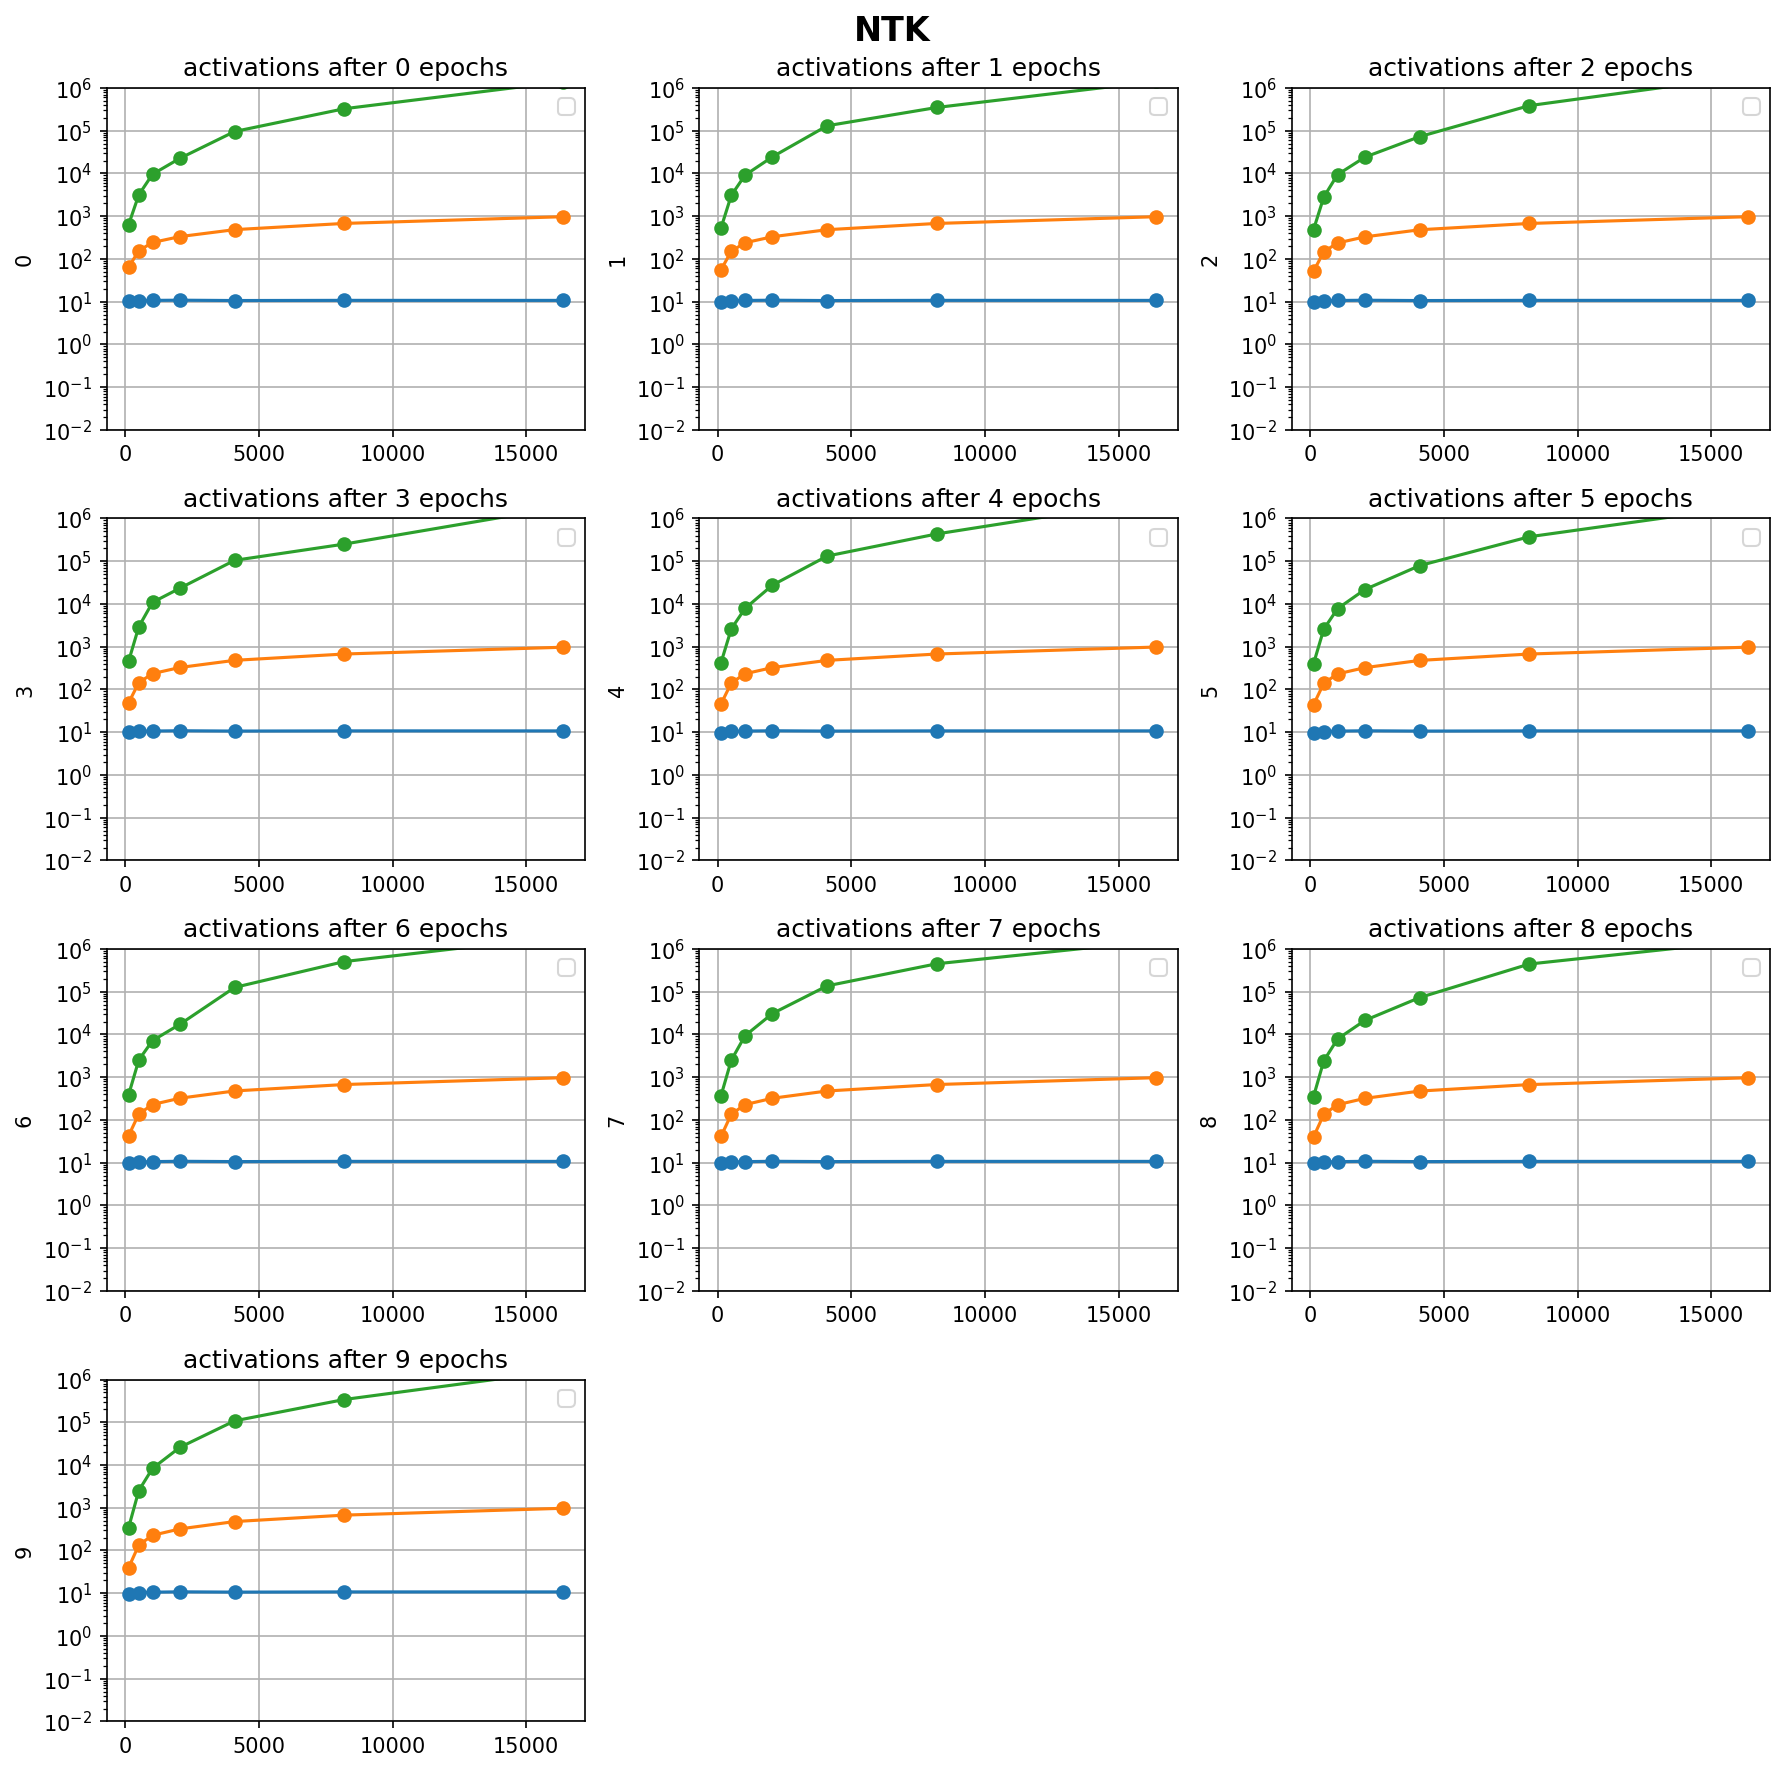

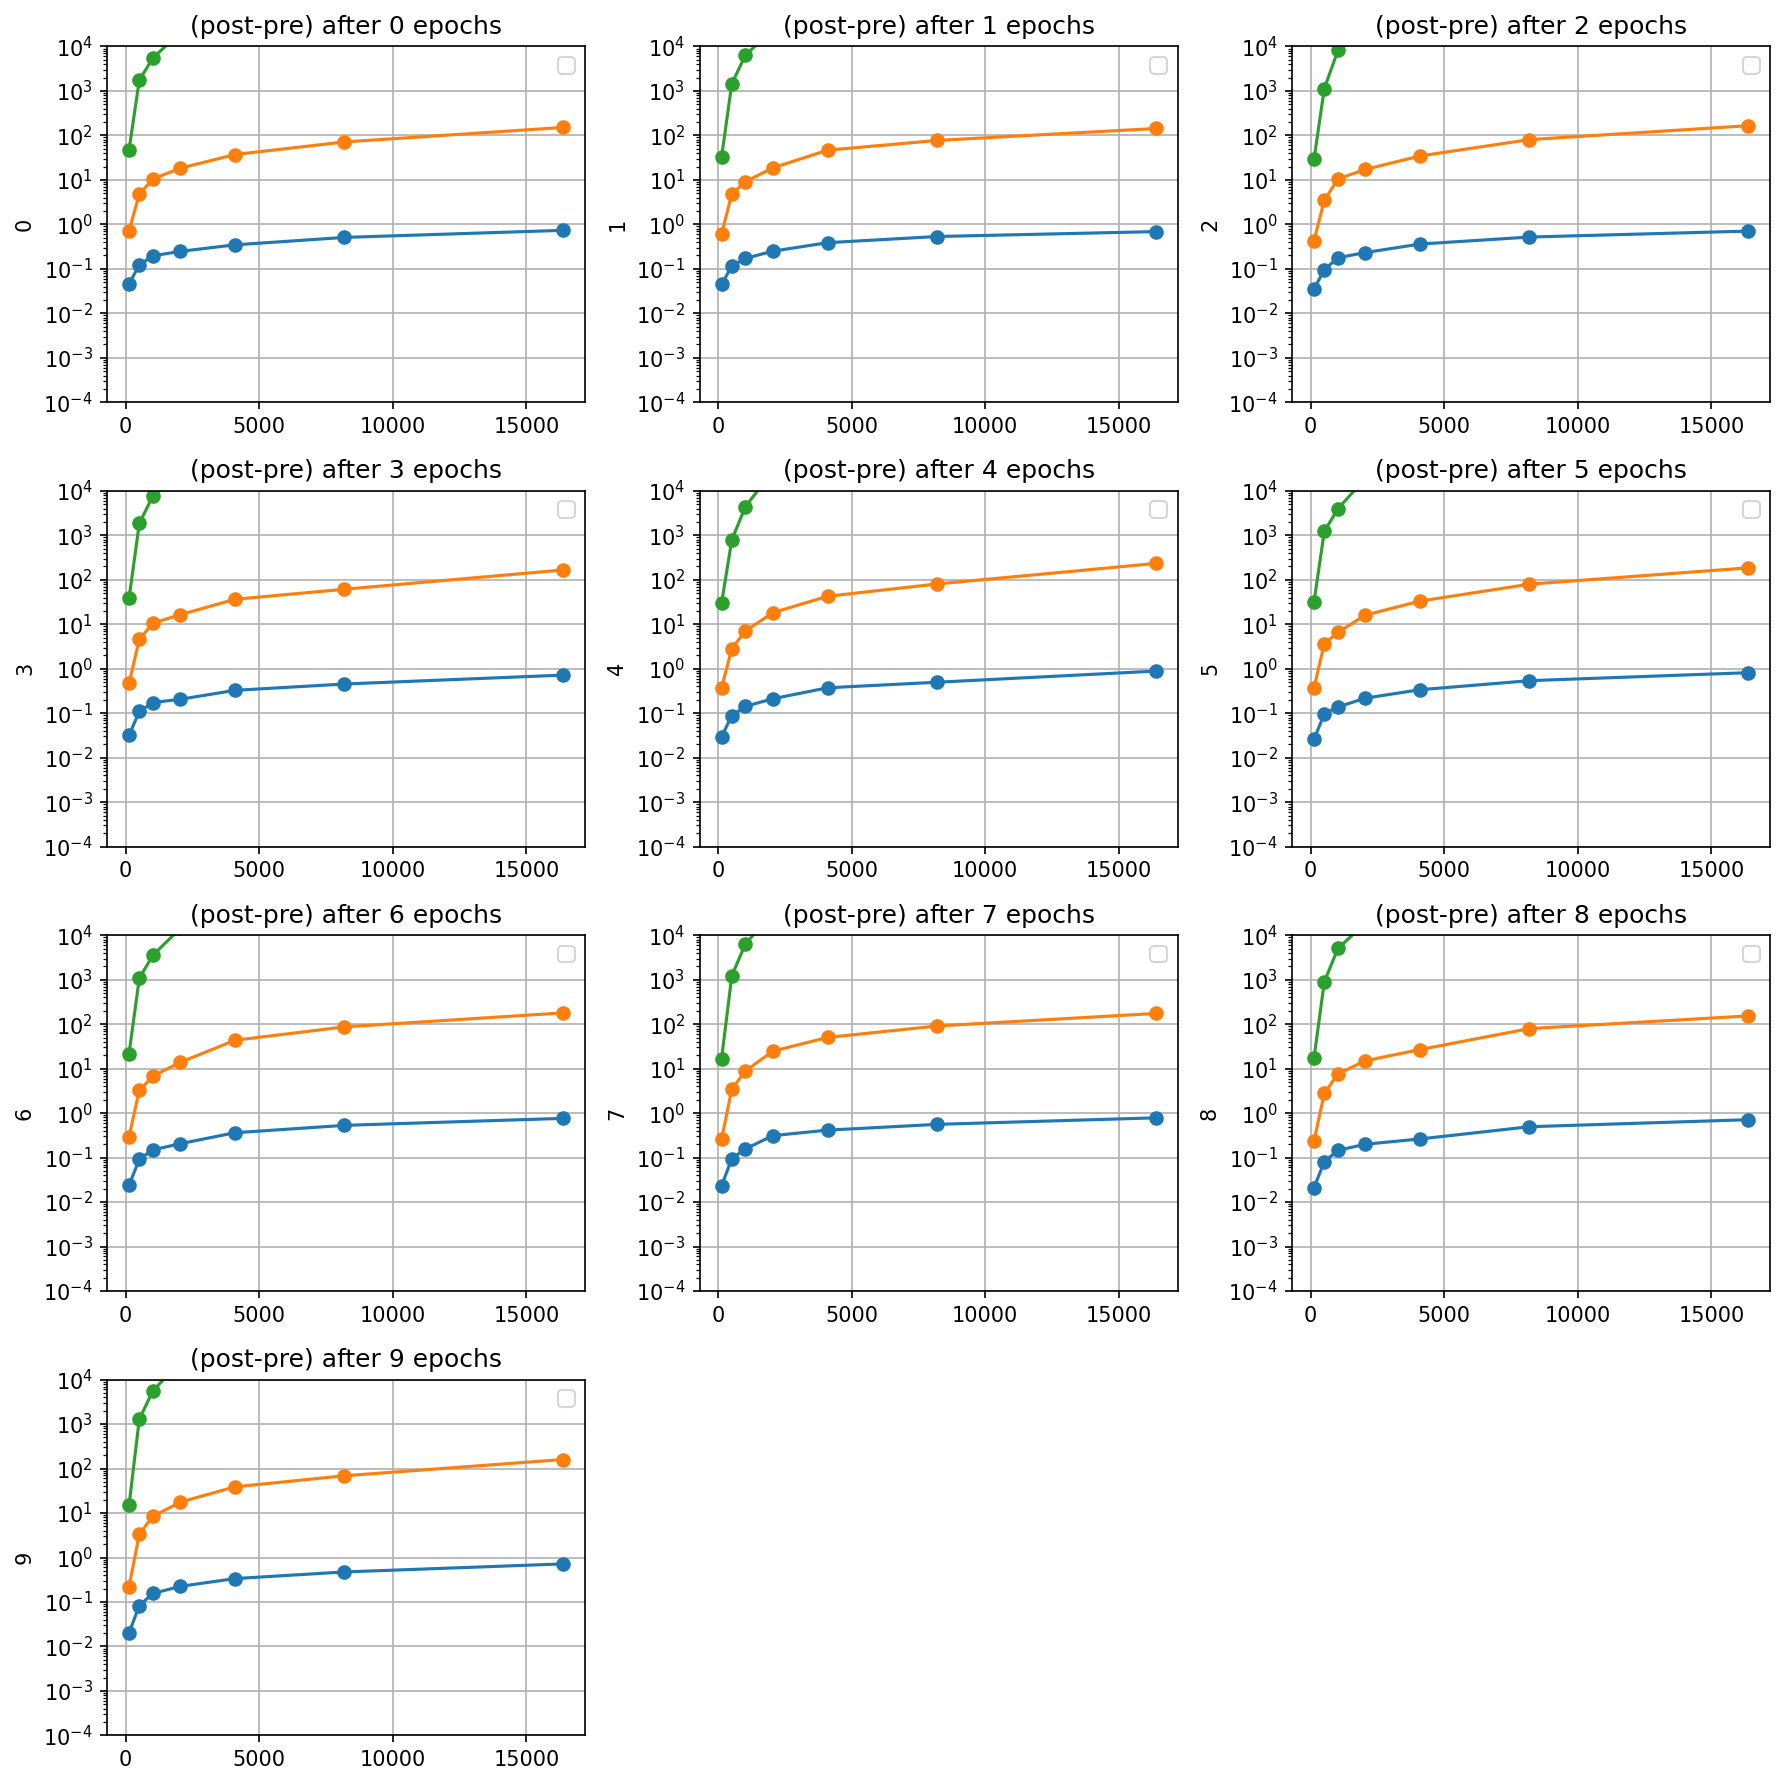

In [27]:
dfNTK = pd.DataFrame(resultsNTK).apply(lambda x: pd.Series(x[0]).apply(pd.Series).stack()).droplevel(1, axis=0)

# Number of unique second-level metrics (e.g., 'loss', 'acc', etc.)
second_levels = dfNTK.columns.levels[1]
n_metrics = len(second_levels)
n_cols = 3
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), dpi=150)
axes = axes.flatten()

for i, second_level in enumerate(second_levels):
    ax = axes[i]
    df_slice = dfNTK.xs(second_level, axis=1, level=1).T
    df_slice.plot(ax=ax, marker="o")
    ax.set_title(f'activations after {second_level} epochs')
    ax.set_xlabel('')
    ax.set_ylim(1e-2, 1e6)
    ax.set_yscale('log')
    ax.set_ylabel(second_level)
    ax.grid(True)
    ax.legend([])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.suptitle('NTK', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

dfNTK = pd.DataFrame(resultsNTK).apply(lambda x: pd.Series(x[1]).apply(pd.Series).stack()).droplevel(1, axis=0)

# Number of unique second-level metrics (e.g., 'loss', 'acc', etc.)
second_levels = dfNTK.columns.levels[1]
n_metrics = len(second_levels)
n_cols = 3
n_rows = math.ceil(n_metrics / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), dpi=150)
axes = axes.flatten()

for i, second_level in enumerate(second_levels):
    ax = axes[i]
    df_slice = dfNTK.xs(second_level, axis=1, level=1).T
    df_slice.plot(ax=ax, marker="o")
    ax.set_title(f'(post-pre) after {second_level} epochs')
    ax.set_xlabel('')
    ax.set_ylim(1e-4, 1e4)
    ax.set_yscale('log')
    ax.set_ylabel(second_level)
    ax.grid(True)
    ax.legend([])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

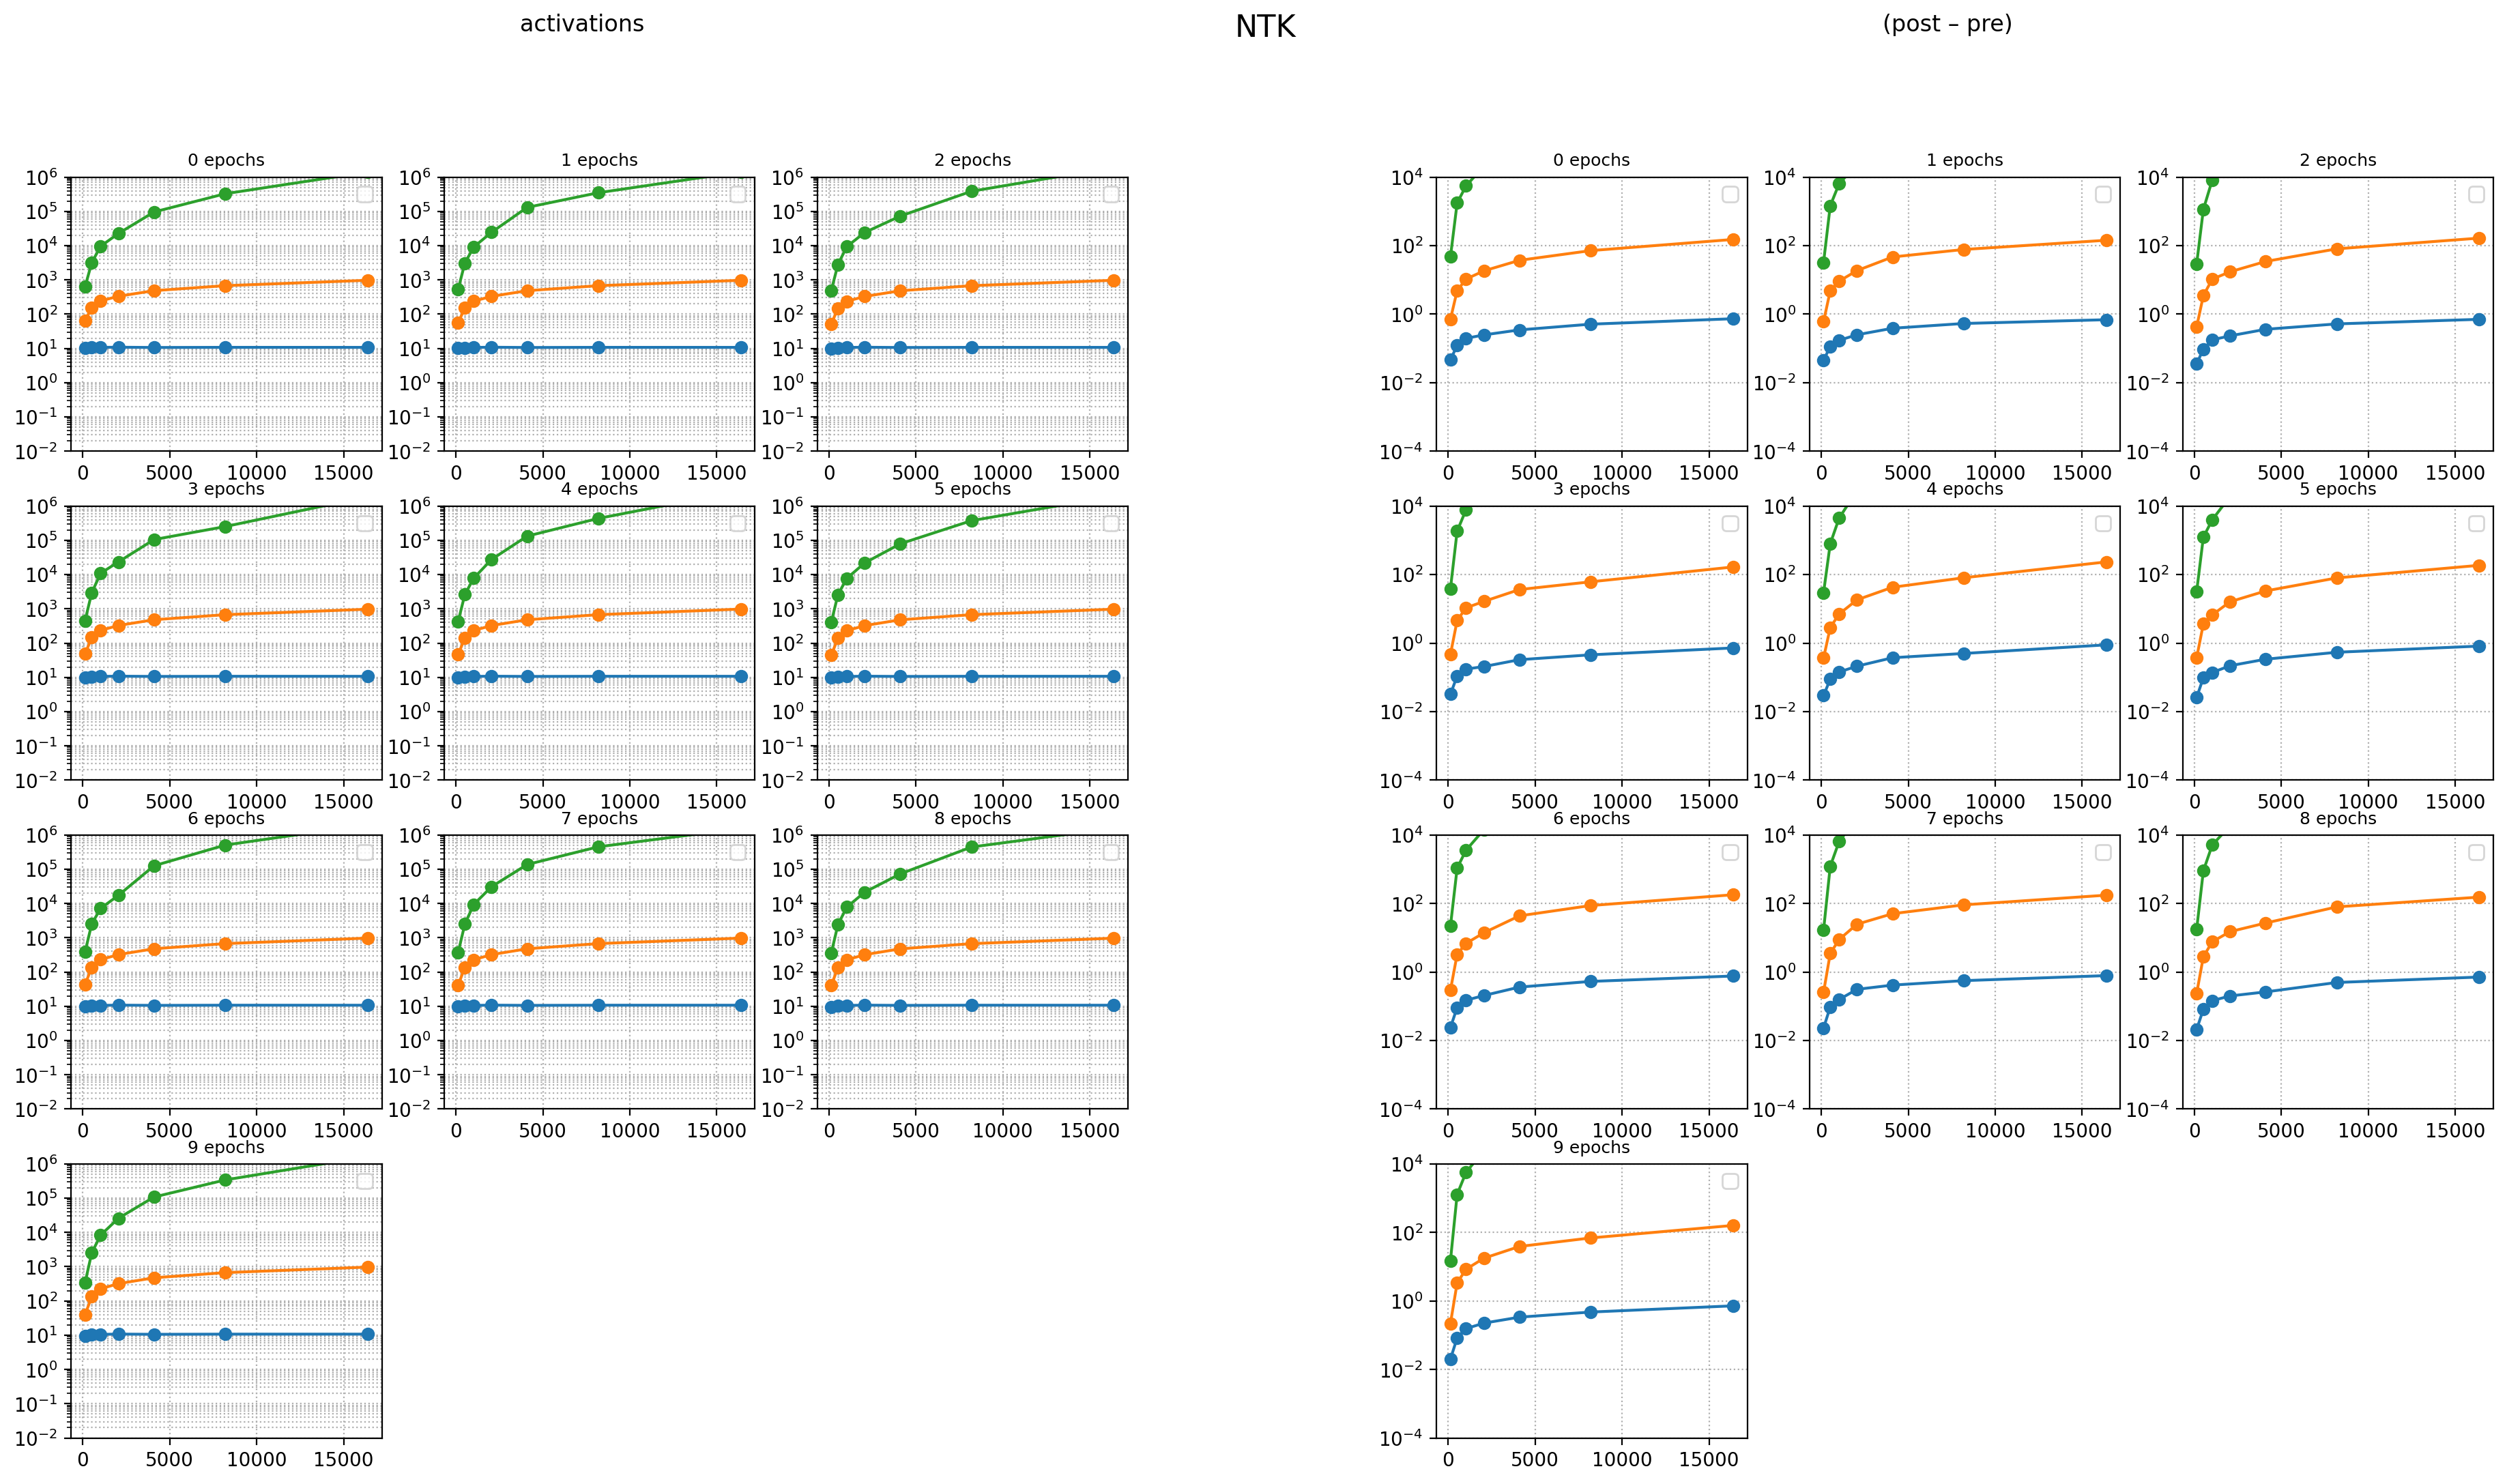

In [24]:
import math, matplotlib.pyplot as plt, pandas as pd

# ------------------------------------------------------------
def make_grid(parent, df, title, yscale, ylim, n_cols=3):
    """Draw one grid inside *parent* (a matplotlib SubFigure)."""
    second_levels = df.columns.levels[1]
    n_metrics     = len(second_levels)
    n_rows        = math.ceil(n_metrics / n_cols)

    parent.suptitle(title, fontsize=12)
    axes = parent.subplots(n_rows, n_cols).flatten()

    for i, sec in enumerate(second_levels):
        ax = axes[i]
        df_slice = df.xs(sec, axis=1, level=1).T
        df_slice.plot(ax=ax, marker="o")
        ax.set_title(f'{sec} epochs', fontsize=9)
        ax.set_xlabel('')
        ax.set_yscale(yscale)
        ax.set_ylim(*ylim)
        ax.grid(True, which='both', ls=':')
        ax.legend([])

    for j in range(i + 1, len(axes)):
        parent.delaxes(axes[j])

# ------------------------------------------------------------
# build the two dataframes exactly as before ------------------
df_act = (pd.DataFrame(resultsNTK)
          .apply(lambda x: pd.Series(x[0]).apply(pd.Series).stack())
          .droplevel(1, axis=0))

df_diff = (pd.DataFrame(resultsNTK)
           .apply(lambda x: pd.Series(x[1]).apply(pd.Series).stack())
           .droplevel(1, axis=0))

# ------------------------------------------------------------
# master figure with two sub-figures --------------------------
fig = plt.figure(figsize=(20, 12), dpi=200)
fig.suptitle('NTK', fontsize=16)

sf_left, sf_right = fig.subfigures(1, 2, wspace=0.001)

make_grid(sf_left,  df_act,  'activations',  'log', (1e-2, 1e6))
make_grid(sf_right, df_diff, '(post – pre)', 'log', (1e-4, 1e4))

# plt.tight_layout()
plt.show()
